### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [70]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [71]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A' ,'e' ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Cis',
       'OMEGA', 'i0', 'Cuc','Crs','Toe', 'OMEGA_dot', 'omega',
       'Crc', 'Cic', 'M0', 'I_dot', 'Del_n', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Cus
Epoch_Time_of_Clock,
2017-11-01 14:00:00,0.00000387243926525000
2017-11-01 16:00:00,0.00000384263694286000
2017-11-01 18:00:00,0.00000376440584660000
2017-11-01 20:00:00,0.00000389851629734000
2017-11-01 22:00:00,0.00000398606061935000


In [73]:
var_name = 'Cus'
sat_var = 1

In [74]:

df = df.iloc[5 : , :]

In [75]:

df.head(7)

,Cus
Epoch_Time_of_Clock,
2017-11-02 12:00:00,0.00000451132655144000
2017-11-02 14:00:00,0.00000493414700031000
2017-11-02 16:00:00,0.00000489875674248000
2017-11-02 18:00:00,0.00000469386577606000
2017-11-02 20:00:00,0.00000475533306599000
2017-11-02 22:00:00,0.00000491924583912000
2017-11-03 12:00:00,0.00000610202550888000


# Enter number of entries per day

In [76]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [77]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [78]:
train = df.copy()[df.index < valid_start_dt][[var_name ]]
train.head()

,Cus
Epoch_Time_of_Clock,
2017-11-02 12:00:00,0.00000451132655144000
2017-11-02 14:00:00,0.00000493414700031000
2017-11-02 16:00:00,0.00000489875674248000
2017-11-02 18:00:00,0.00000469386577606000
2017-11-02 20:00:00,0.00000475533306599000


In [79]:
train.tail(6)

,Cus
Epoch_Time_of_Clock,
2017-11-20 12:00:00,0.00001104921102520000
2017-11-20 14:00:00,0.00001117587089540000
2017-11-20 16:00:00,0.00001054815948010000
2017-11-20 18:00:00,0.00001023523509500000
2017-11-20 20:00:00,0.00001030042767520000
2017-11-20 22:00:00,0.00001066923141480000


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [80]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[[var_name]] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [81]:
tensor_structure = {'X':(range(-T+1, 1), [var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), [var_name])} ,freq = None)

In [82]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00 -0.75246262196934154964 -0.52367906394402607972   
2017-11-03 12:00:00 -0.52367906394402607972 -0.51212433879056395991   
2017-11-03 14:00:00 -0.51212433879056395991 -0.61149497510454831062   
2017-11-03 16:00:00 -0.61149497510454831062 -0.61226529011505492761   
2017-11-03 18:00:00 -0.61226529011505492761 -0.55449166435187968727   
2017-11-03 20:00:00 -0.55449166435187968727  0.07254475394401449506   
2017-11-03 22:00:00  0.07254475394401449506  0.28746264178434793868   
2017-11-04 12:00:00  0.28746264178434793868  0.32982996734566361052   
2017-11-04 14:00:00  0.32982996734566361052  0.28746264178434793868   
2017-11-04 16:00:00  0.28746264178434793868  0.29208453184738647490   
2017-11-04 18:00:00  0.29208453184738647490  0.30055799695882345901   
2017-11-04 20:00:00  0.30055799695882345901  0.84979259922250838244   
2017-11-04 22:00:00  0.84979259922250838244  0.97612426091249149263   
2017-11-05 12:00:00  0.97612426091249149263  1.02311347653271078606   
2017-11-05 14:00:00  1.02311347653271078606  1.08859025236373074819   
2017-11-05 16:00:00  1.08859025236373074819  1.14251230309918638817   
2017-11-05 18:00:00  1.14251230309918638817  1.09013088238474376013   
2017-11-05 20:00:00  1.09013088238474376013  1.36282239602133747880   
2017-11-05 22:00:00  1.36282239602133747880  1.35434893088508734316   
2017-11-06 12:00:00  1.35434893088508734316  1.36205208099015284695   
2017-11-06 14:00:00  1.36205208099015284695  1.52073697311313860148   
2017-11-06 16:00:00  1.52073697311313860148  1.64783894978467881920   
2017-11-06 18:00:00  1.64783894978467881920  1.56618555871234477195   
2017-11-06 20:00:00  1.56618555871234477195  1.47836964755595778875   
2017-11-06 22:00:00  1.47836964755595778875  1.34048326069597045773   
2017-11-07 12:00:00  1.34048326069597045773  1.27269553981275351795   
2017-11-07 14:00:00  1.27269553981275351795  1.44986799214653916401   
2017-11-07 16:00:00  1.44986799214653916401  1.63551390961657494572   
2017-11-07 18:00:00  1.63551390961657494572  1.57774028384926401358   
2017-11-07 20:00:00  1.57774028384926401358  1.19412340878244482845   
...                                     ...                     ...   
2017-11-15 12:00:00 -0.97431334490423415762 -0.90421467897709073558   
2017-11-15 14:00:00 -0.90421467897709073558 -0.86569892846830731603   
2017-11-15 16:00:00 -0.86569892846830731603 -0.72087970655098176920   
2017-11-15 18:00:00 -0.72087970655098176920 -0.75092199194832853770   
2017-11-15 20:00:00 -0.75092199194832853770 -0.47823047834068455053   
2017-11-15 22:00:00 -0.47823047834068455053 -0.47283827327127442297   
2017-11-16 12:00:00 -0.47283827327127442297 -0.42122716758801620474   
2017-11-16 14:00:00 -0.42122716758801620474 -0.37346763695729034982   
2017-11-16 16:00:00 -0.37346763695729034982 -0.21401242984861185148   
2017-11-16 18:00:00 -0.21401242984861185148 -0.20553896473717556126   
2017-11-16 20:00:00 -0.20553896473717556126  0.10566829937925173444   
2017-11-16 22:00:00  0.10566829937925173444  0.10412766936237428939   
2017-11-17 12:00:00  0.10412766936237428939  0.09334325921941838411   
2017-11-17 14:00:00  0.09334325921941838411  0.11645270952220765359   
2017-11-17 16:00:00  0.11645270952220765359  0.27051571156147602437   
2017-11-17 18:00:00  0.27051571156147602437  0.33599248742558029956   
2017-11-17 20:00:00  0.33599248742558029956  0.65567321665344391324   
2017-11-17 22:00:00  0.65567321665344391324  0.65721384667445703620   
2017-11-18 12:00:00  0.65721384667445703620  0.55784321036047257447   
2017-11-18 14:00:00  0.55784321036047257447  0.53165250001565789173   
2017-11-18 16:00:00  0.53165250001565789173  0.65952479170597588798   
2017-11-18 18:00:00  0.6

In [83]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [84]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][[var_name]]
valid[[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.05007450187976081324 1.17948742360349956293   
2017-11-22 12:00:00 1.17948742360349956293 0.90987717000893197916   
2017-11-22 14:00:00 0.90987717000893197916 0.75350322295055083277   
2017-11-22 16:00:00 0.75350322295055083277 0.67493109191197109276   
2017-11-22 18:00:00 0.67493109191197109276 0.71652810245864462235   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 0.90987717000893197916 0.75350322295055083277   
2017-11-22 12:00:00 0.75350322295055083277 0.67493109191197109276   
2017-11-22 14:00:00 0.67493109191197109276 0.71652810245864462235   
2017-11-22 16:00:00 0.71652810245864462235 0.63949660144107789428   
2017-11-22 18:00:00 0.63949660144107789428 0.79201897345933314210   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 0.67493109191197109276 0.71652810245864462235   
2017-11-22 12:00:00 0.71652810245864462235 0.63949660144107789428   
2017-11-22 14:00:00 0.63949660144107789428 0.79201897345933314210   
2017-11-22 16:00:00 0.79201897345933314210 0.58326360569891644303   
2017-11-22 18:00:00 0.58326360569891644303 0.45153973895606569489   

tensor                                   X                         \
feature                                Cus                          
time step                              t-5                    t-4   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.28270963492865952560 1.37514743618944135228   
2017-11-22 12:00:00 1.37514743618944135228 1.08627930735288935615   
2017-11-22 14:00:00 1.08627930735288935615 0.93067567531328521113   
2017-11-22 16:00:00 0.93067567531328521113 0.90063338988285346343   
2017-11-22 18:00:00 0.90063338988285346343 1.01464001139646131655   

tensor                                                             \
feature                                                             
time step                              t-3                    t-2   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.08627930735288935615 0.93067567531328521113   
2017-11-22 12:00:00 0.93067567531328521113 0.90063338988285346343   
2017-11-22 14:00:00 0.90063338988285346343 1.01464001139646131655   
2017-11-22 16:00:00 1.01464001139646131655 1.05007450187976081324   
2017-11-22 18:00:00 1.05007450187976081324 1.17948742360349956293   

tensor                                                             
feature                                                            
time step                              t-1                      t  
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 0.90063338988285346343 1.01464001139646131655  
2017-11-22 12:00:00 1.01464001139646131655 1.05007450187976081324  
2017-11-22 14:00:00 1.05007450187976081324 1.17948742360349956293  
2017-11-22 16:00:00 1.17948742360349956293 0.90987717000893197916  
2017-11-22 18:00:00 0.90987717000893197916 0.75350322295055083277

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [85]:
#Image('./images/simple_encoder_decoder.png')

In [86]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [87]:
LATENT_DIM = 64
BATCH_SIZE = 8
EPOCHS = 10

In [88]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [89]:
model.compile(optimizer='RMSprop', loss='mse')

In [90]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 6, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 1)              65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 6)                 0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [91]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [92]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [94]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/10
103/103 [==============================] - 2s 16ms/step - loss: 0.4893 - val_loss: 0.1837
Epoch 2/10
103/103 [==============================] - 0s 1ms/step - loss: 0.3874 - val_loss: 0.1914
Epoch 3/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3634 - val_loss: 0.1860
Epoch 4/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3457 - val_loss: 0.1799
Epoch 5/10
103/103 [==============================] - 0s 3ms/step - loss: 0.3299 - val_loss: 0.1742
Epoch 6/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3151 - val_loss: 0.1687
Epoch 7/10
103/103 [==============================] - 0s 2ms/step - loss: 0.3011 - val_loss: 0.1632
Epoch 8/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2879 - val_loss: 0.1578
Epoch 9/10
103/103 [==============================] - 0s 2ms/step - loss: 0.2753 - val_loss: 0.1527
Epoch 10/10
103/103 [==============================] -

In [95]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [35]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][[var_name]]
test[[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.75940650447656921074 -0.95813867441938493918   
2017-11-25 22:00:00 -0.95813867441938493918 -0.85995084342047001247   
2017-11-26 12:00:00 -0.85995084342047001247 -0.83638576397904351722   
2017-11-26 14:00:00 -0.83638576397904351722 -0.83638576397904351722   
2017-11-26 16:00:00 -0.83638576397904351722 -0.93693010292294431895   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.85995084342047001247 -0.83638576397904351722   
2017-11-25 22:00:00 -0.83638576397904351722 -0.83638576397904351722   
2017-11-26 12:00:00 -0.83638576397904351722 -0.93693010292294431895   
2017-11-26 14:00:00 -0.93693010292294431895 -1.16551137349381606079   
2017-11-26 16:00:00 -1.16551137349381606079 -1.26055719390363307753   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.83638576397904351722 -0.93693010292294431895   
2017-11-25 22:00:00 -0.93693010292294431895 -1.16551137349381606079   
2017-11-26 12:00:00 -1.16551137349381606079 -1.26055719390363307753   
2017-11-26 14:00:00 -1.26055719390363307753 -1.20714301383836808412   
2017-11-26 16:00:00 -1.20714301383836808412 -1.16708237879047360686   

tensor                                    X                          \
feature                                 Cus                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.26061232299449083039 -0.48133856708207556352   
2017-11-25 22:00:00 -0.48133856708207556352 -0.34387560367937808348   
2017-11-26 12:00:00 -0.34387560367937808348 -0.38157973078650353482   
2017-11-26 14:00:00 -0.38157973078650353482 -0.42399687377938444222   
2017-11-26 16:00:00 -0.42399687377938444222 -0.55203380540213797811   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.34387560367937808348 -0.38157973078650353482   
2017-11-25 22:00:00 -0.38157973078650353482 -0.42399687377938444222   
2017-11-26 12:00:00 -0.42399687377938444222 -0.55203380540213797811   
2017-11-26 14:00:00 -0.55203380540213797811 -0.75940650447656921074   
2017-11-26 16:00:00 -0.75940650447656921074 -0.95813867441938493918   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-25 20:00:00 -0.42399687377938444222 -0.55203380540213797811  
2017-11-25 22:00:00 -0.55203380540213797811 -0.75940650447656921074  
2017-11-26 12:00:00 -0.75940650447656921074 -0.95813867441938493918  
2017-11-26 14:00:00 -0.95813867441938493918 -0.85995084342047001247  
2017-11-26 16:00:00 -0.85995084342047001247 -0.83638576397904351722

In [36]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.75940650447656921074 -0.95813867441938493918   
2017-11-25 22:00:00 -0.95813867441938493918 -0.85995084342047001247   
2017-11-26 12:00:00 -0.85995084342047001247 -0.83638576397904351722   
2017-11-26 14:00:00 -0.83638576397904351722 -0.83638576397904351722   
2017-11-26 16:00:00 -0.83638576397904351722 -0.93693010292294431895   
2017-11-26 18:00:00 -0.93693010292294431895 -1.16551137349381606079   
2017-11-26 20:00:00 -1.16551137349381606079 -1.26055719390363307753   
2017-11-26 22:00:00 -1.26055719390363307753 -1.20714301383836808412   
2017-11-27 12:00:00 -1.20714301383836808412 -1.16708237879047360686   
2017-11-27 14:00:00 -1.16708237879047360686 -1.14508830464570432461   
2017-11-27 16:00:00 -1.14508830464570432461 -1.20164449530006689493   
2017-11-27 18:00:00 -1.20164449530006689493 -1.38937962817471527543   
2017-11-27 20:00:00 -1.38937962817471527543 -1.29826132100654167978   
2017-11-27 22:00:00 -1.29826132100654167978 -1.28098026275174459165   
2017-11-28 12:00:00 -1.28098026275174459165 -1.27233973362012919850   
2017-11-28 14:00:00 -1.27233973362012919850 -1.25427317271700378143   
2017-11-28 16:00:00 -1.25427317271700378143 -1.26134269655196185056   
2017-11-28 18:00:00 -1.26134269655196185056 -1.34931899312682057612   
2017-11-28 20:00:00 -1.34931899312682057612 -1.02019338361204825461   
2017-11-28 22:00:00 -1.02019338361204825461 -1.01312385978130747866   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.85995084342047001247 -0.83638576397904351722   
2017-11-25 22:00:00 -0.83638576397904351722 -0.83638576397904351722   
2017-11-26 12:00:00 -0.83638576397904351722 -0.93693010292294431895   
2017-11-26 14:00:00 -0.93693010292294431895 -1.16551137349381606079   
2017-11-26 16:00:00 -1.16551137349381606079 -1.26055719390363307753   
2017-11-26 18:00:00 -1.26055719390363307753 -1.20714301383836808412   
2017-11-26 20:00:00 -1.20714301383836808412 -1.16708237879047360686   
2017-11-26 22:00:00 -1.16708237879047360686 -1.14508830464570432461   
2017-11-27 12:00:00 -1.14508830464570432461 -1.20164449530006689493   
2017-11-27 14:00:00 -1.20164449530006689493 -1.38937962817471527543   
2017-11-27 16:00:00 -1.38937962817471527543 -1.29826132100654167978   
2017-11-27 18:00:00 -1.29826132100654167978 -1.28098026275174459165   
2017-11-27 20:00:00 -1.28098026275174459165 -1.27233973362012919850   
2017-11-27 22:00:00 -1.27233973362012919850 -1.25427317271700378143   
2017-11-28 12:00:00 -1.25427317271700378143 -1.26134269655196185056   
2017-11-28 14:00:00 -1.26134269655196185056 -1.34931899312682057612   
2017-11-28 16:00:00 -1.34931899312682057612 -1.02019338361204825461   
2017-11-28 18:00:00 -1.02019338361204825461 -1.01312385978130747866   
2017-11-28 20:00:00 -1.01312385978130747866 -1.06182502395660049999   
2017-11-28 22:00:00 -1.06182502395660049999 -1.07046555308399859996   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 20:00:00 -0.83638576397904351722 -0.93693010292294431895   
2017-11-25 22:00:00 -0.93693010292294431895 -1.16551137349381606079   
2017-11-26 12:00:00 -1.16551137349381606079 -1.26055719390363307753   
2017-11-26 14:00:00 -1.26055719390363307753 -1.20714301383836808412   
2017-11-26 16:00:00 -1

In [37]:
test_inputs.dataframe.shape

(20, 12)

In [38]:
predictions = model.predict(test_inputs['X'])

In [39]:
predictions

array([[-0.15008211, -0.23456267, -0.2656395 , -0.26428205, -0.2463526 ,
        -0.22255756],
       [-0.21185876, -0.33101243, -0.37719044, -0.3785098 , -0.35652968,
        -0.32590368],
       [-0.28700462, -0.4489383 , -0.5142261 , -0.5196125 , -0.49357542,
        -0.45550326],
       [-0.33334774, -0.51898277, -0.5922652 , -0.5964925 , -0.56504637,
        -0.5203731 ],
       [-0.36316812, -0.5628161 , -0.63952214, -0.6413934 , -0.6052441 ,
        -0.55551916],
       [-0.3837652 , -0.5924356 , -0.6706105 , -0.6700389 , -0.63004154,
        -0.57644707],
       [-0.4115478 , -0.6344576 , -0.71750647, -0.7165208 , -0.6737651 ,
        -0.6167902 ],
       [-0.46426225, -0.7169959 , -0.81319845, -0.8153402 , -0.7706961 ,
        -0.7098821 ],
       [-0.51473194, -0.7960927 , -0.9050223 , -0.9104541 , -0.86444765,
        -0.80046517],
       [-0.5482984 , -0.84678715, -0.9615968 , -0.96688116, -0.91824913,
        -0.85105544],
       [-0.5679012 , -0.8750293 , -0.99144405, -0.

In [40]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-25 20:00:00  t+1 0.00000768660142416890 0.00000624172389507000
1 2017-11-25 22:00:00  t+1 0.00000754011180607256 0.00000577047467232000
2 2017-11-26 12:00:00  t+1 0.00000736192009192218 0.00000600330531597000
3 2017-11-26 14:00:00  t+1 0.00000725202767580687 0.00000605918467045000
4 2017-11-26 16:00:00  t+1 0.00000718131525856675 0.00000605918467045000
              timestamp    h             prediction                 actual
115 2017-11-28 14:00:00  t+6 0.00000571224921835878 0.00000564008951187000
116 2017-11-28 16:00:00  t+6 0.00000570605686607602 0.00000552460551262000
117 2017-11-28 18:00:00  t+6 0.00000571560432788330 0.00000550411641598000
118 2017-11-28 20:00:00  t+6 0.00000572310336091231 0.00000558048486710000
119 2017-11-28 22:00:00  t+6 0.00000567714282674456 0.00000568293035030000
(120, 4)


In [41]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.28121335980099460006
t+2   0.16704043674396376606
t+3   0.13532710428707303563
t+4   0.14232604611516971871
t+5   0.16088082852116505905
t+6   0.18945147409176588127
Name: APE, dtype: float64

In [42]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

9.452638942908945e-07

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

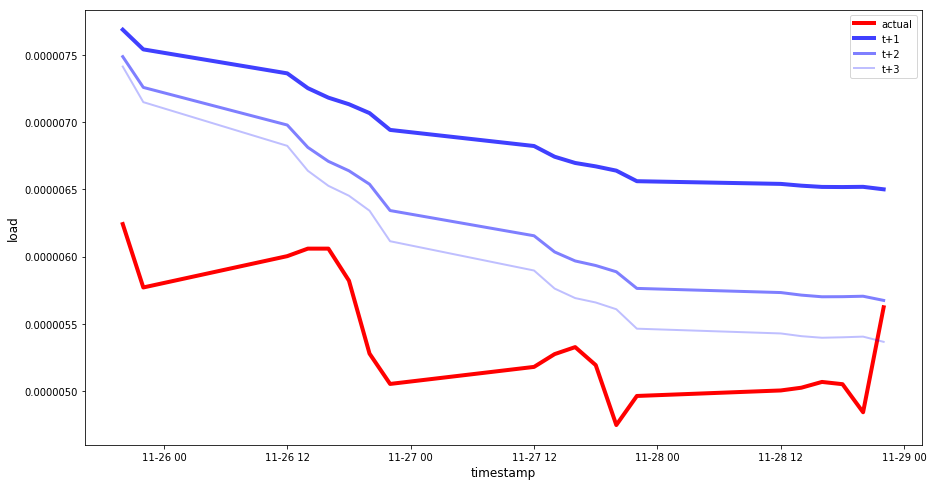

In [43]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [44]:
a = df.iloc[156:162  , :]
a

,Cus
Epoch_Time_of_Clock,
2017-11-28 22:00:00,0.00000484287738800000
2017-11-29 12:00:00,0.00000562332570553000
2017-11-29 14:00:00,0.00000564008951187000
2017-11-29 16:00:00,0.00000552460551262000
2017-11-29 18:00:00,0.00000550411641598000
2017-11-29 20:00:00,0.00000558048486710000


In [45]:
new_df = pd.DataFrame()

In [46]:
columns = [var_name] 

In [47]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [48]:
new_df = new_df.dropna( how = 'any')

In [49]:
new_df

,Cus
Epoch_Time_of_Clock,
2017-11-28 22:00:00,0.00000484287738800000
2017-11-29 12:00:00,0.00000562332570553000
2017-11-29 14:00:00,0.00000564008951187000
2017-11-29 16:00:00,0.00000552460551262000
2017-11-29 18:00:00,0.00000550411641598000
2017-11-29 20:00:00,0.00000558048486710000


In [50]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [51]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [52]:
date

DatetimeIndex(['2017-11-29 22:00:00', '2017-11-30 12:00:00',
               '2017-11-30 14:00:00', '2017-11-30 16:00:00',
               '2017-11-30 18:00:00', '2017-11-30 20:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq=None)

In [53]:
new_df.index= date

In [54]:
new_df.columns

Index(['Cus'], dtype='object')

In [55]:
print(new_df)
print(new_df.columns)

                                       Cus
Epoch_Time_of_Clock                       
2017-11-29 22:00:00 0.00000484287738800000
2017-11-30 12:00:00 0.00000562332570553000
2017-11-30 14:00:00 0.00000564008951187000
2017-11-30 16:00:00 0.00000552460551262000
2017-11-30 18:00:00 0.00000550411641598000
2017-11-30 20:00:00 0.00000558048486710000
Index(['Cus'], dtype='object')


In [56]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Cus
Epoch_Time_of_Clock                        
2017-11-29 22:00:00 -1.34931899312682057612
2017-11-30 12:00:00 -1.02019338361204825461
2017-11-30 14:00:00 -1.01312385978130747866
2017-11-30 16:00:00 -1.06182502395660049999
2017-11-30 18:00:00 -1.07046555308399859996


In [57]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                                 Cus                           
time step                               t-5                     t-4   
Epoch_Time_of_Clock                                                   
2017-11-30 20:00:00 -1.34931899312682057612 -1.02019338361204825461   

tensor                                                               \
feature                                                               
time step                               t-3                     t-2   
Epoch_Time_of_Clock                                                   
2017-11-30 20:00:00 -1.01312385978130747866 -1.06182502395660049999   

tensor                                                               
feature                                                              
time step                               t-1                       t  
Epoch_Time_of_Clock                                                  
2017-11-

In [58]:
predictions = model.predict(inputs['X'])

In [59]:
predictions

array([[-0.5239381 , -0.80438083, -0.9072551 , -0.9054133 , -0.8529877 ,
        -0.7841143 ]], dtype=float32)

In [60]:
print(predictions.shape)


(1, 6)


In [61]:
results = predictions[-1, :]

In [62]:
results

array([-0.5239381 , -0.80438083, -0.9072551 , -0.9054133 , -0.8529877 ,
       -0.7841143 ], dtype=float32)

In [63]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Cus
0,-0.52393811941146850586
1,-0.80438083410263061523
2,-0.90725511312484741211
3,-0.90541332960128784180
4,-0.85298770666122436523
5,-0.78411430120468139648


In [64]:
res_df.index = date
res_df

,Cus
Epoch_Time_of_Clock,
2017-11-29 22:00:00,-0.52393811941146850586
2017-11-30 12:00:00,-0.80438083410263061523
2017-11-30 14:00:00,-0.90725511312484741211
2017-11-30 16:00:00,-0.90541332960128784180
2017-11-30 18:00:00,-0.85298770666122436523
2017-11-30 20:00:00,-0.78411430120468139648


In [65]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [66]:
# final generated ouput
res_df

,Cus
Epoch_Time_of_Clock,
2017-11-29 22:00:00,0.00000680008497511153
2017-11-30 12:00:00,0.00000613507745583775
2017-11-30 14:00:00,0.00000589113369642291
2017-11-30 16:00:00,0.00000589550108998083
2017-11-30 18:00:00,0.00000601981673753471
2017-11-30 20:00:00,0.00000618313470113208


In [69]:
res_df.to_csv('SA1_Cus.csv')